In [42]:
import os  # Add this import at the top of your script

# Define the output directory
output_directory = 'output'

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Compile detected events into a DataFrame and export to CSV
detect_df = pd.DataFrame({
    'filename': fnames, 
    'time_abs(%Y-%m-%dT%H:%M:%S.%f)': [dt.strftime('%Y-%m-%dT%H:%M:%S.%f') for dt in detection_times],
    'time_rel(sec)': tr_times[on_off[:, 0]]
})

# Save to CSV in the output directory
detect_df.to_csv(f'{output_directory}/dettect_catalog.csv', index=False)


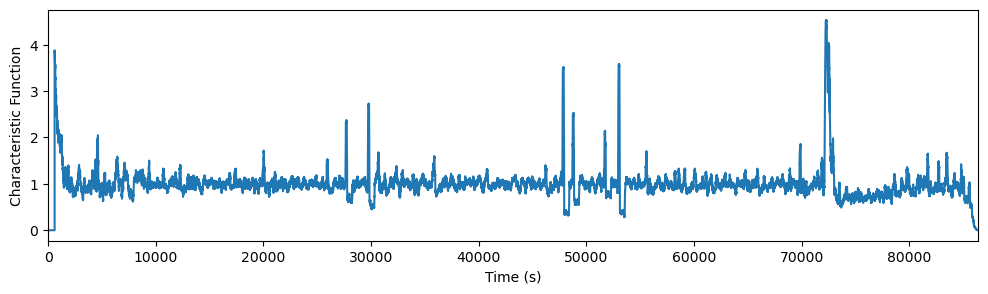

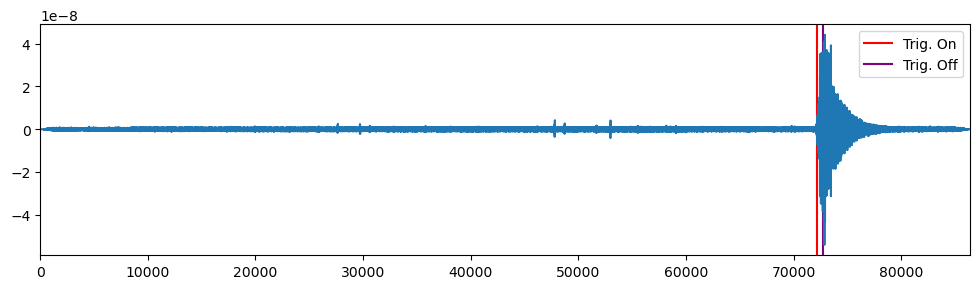

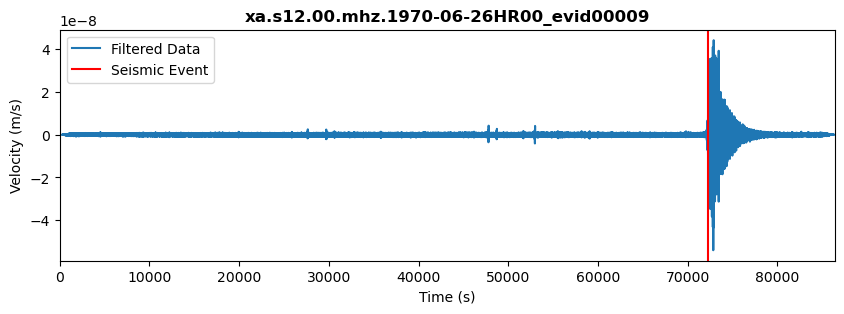

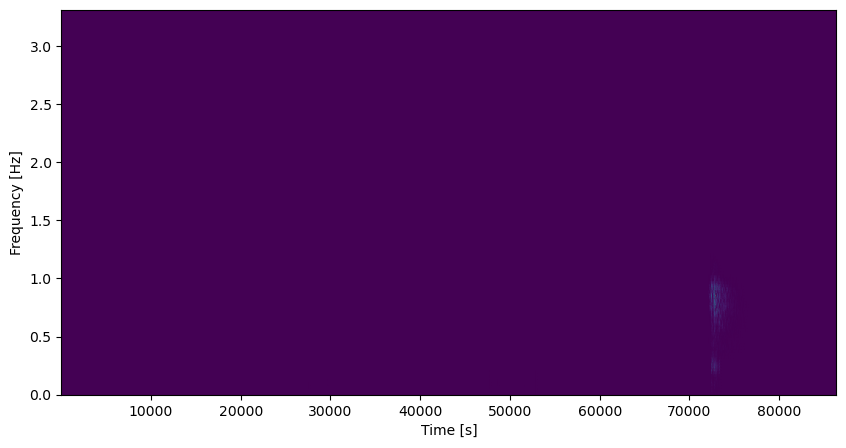

In [43]:
# Import necessary libraries
import numpy as np
import pandas as pd
from obspy import read
from obspy.signal.trigger import classic_sta_lta, trigger_onset
from obspy.core import UTCDateTime
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

# Function to filter the seismic data to remove noise (e.g., high-pass filter)
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Read in the catalog (for training data with labeled events)
cat_directory = r'C:\Users\R Durga Bhavani\Downloads\space_apps_2024_seismic_detection\space_apps_2024_seismic_detection\data\lunar\training\catalogs\apollo12_catalog_GradeA_final.csv'
cat_file = cat_directory 
cat = pd.read_csv(cat_file)

# Select a seismic event from the catalog
row = cat.iloc[6]
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], '%Y-%m-%dT%H:%M:%S.%f')
arrival_time_rel = row['time_rel(sec)']
test_filename = row.filename

# Read the MiniSEED file corresponding to that detection
data_directory = r'C:\Users\R Durga Bhavani\Downloads\space_apps_2024_seismic_detection\space_apps_2024_seismic_detection\data\lunar\training\data\S12_GradeA'
mseed_file = f'{data_directory}\\{test_filename}.mseed'
st = read(mseed_file)

# Extract trace data
tr = st[0].copy()
tr_times = tr.times()
tr_data = tr.data
fs = tr.stats.sampling_rate  # Sampling frequency

# Apply bandpass filter (to handle planetary-specific noise and anomalies)
lowcut = 0.01  # Adjust to target specific seismic frequencies
highcut = 1.0
tr_data_filt = bandpass_filter(tr_data, lowcut, highcut, fs)

# Function to handle missing data
def handle_missing_data(data):
    data = np.nan_to_num(data)  # Replace NaN with zeros or mean of neighbors
    return data

tr_data_filt = handle_missing_data(tr_data_filt)

# Apply Short-Term Average / Long-Term Average (STA/LTA) algorithm
sta_len = 120  # Short-term window in seconds
lta_len = 600  # Long-term window in seconds
df = fs  # Sampling frequency
cft = classic_sta_lta(tr_data_filt, int(sta_len * df), int(lta_len * df))

# Plot characteristic function for STA/LTA
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.plot(tr_times, cft)
ax.set_xlim([min(tr_times), max(tr_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic Function')

# Define trigger thresholds and identify seismic events
thr_on = 4  # On threshold
thr_off = 1.5  # Off threshold
on_off = np.array(trigger_onset(cft, thr_on, thr_off))

# Plot triggers
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
for i in range(len(on_off)):
    triggers = on_off[i]
    ax.axvline(x=tr_times[triggers[0]], color='red', label='Trig. On')
    ax.axvline(x=tr_times[triggers[1]], color='purple', label='Trig. Off')

# Plot filtered trace with marked detections
ax.plot(tr_times, tr_data_filt)
ax.set_xlim([min(tr_times), max(tr_times)])
ax.legend()

# Convert time to absolute
starttime = tr.stats.starttime.datetime
detection_times = []
fnames = []
for i in range(len(on_off)):
    triggers = on_off[i]
    on_time = starttime + timedelta(seconds=tr_times[triggers[0]])
    detection_times.append(on_time)
    fnames.append(test_filename)

# Compile detected events into a DataFrame and export to CSV
detect_df = pd.DataFrame({
    'filename': fnames, 
    'time_abs(%Y-%m-%dT%H:%M:%S.%f)': [dt.strftime('%Y-%m-%dT%H:%M:%S.%f') for dt in detection_times],
    'time_rel(sec)': tr_times[on_off[:, 0]]
})

detect_df.to_csv('output/dettect_catalog.csv', index=False)

# Optional: Machine Learning Approach (If Applicable)
# You could add a section here using libraries such as scikit-learn or TensorFlow
# to train a machine learning model for automatic detection using seismic data
# from both Earth and planetary datasets.

# Visualization of Seismic Data (Creativity)
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(tr_times, tr_data_filt, label='Filtered Data')
ax.set_xlim([min(tr_times), max(tr_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Mark event detections on the plot
for trigger in on_off:
    ax.axvline(x=tr_times[trigger[0]], color='red', label='Seismic Event')

plt.legend()
plt.show()

# Optional: Spectrogram visualization for additional data representation
from scipy import signal
f, t, Sxx = signal.spectrogram(tr_data_filt, fs)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.pcolormesh(t, f, Sxx, shading='gouraud')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [s]')
plt.show()


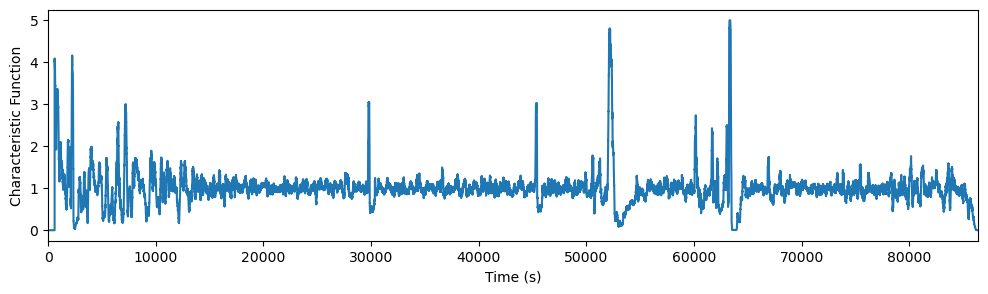

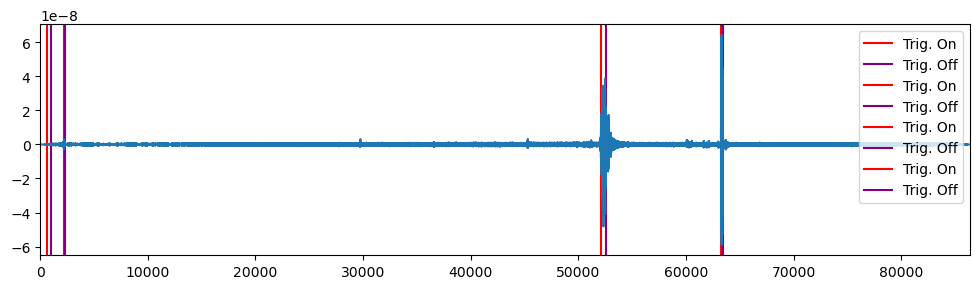

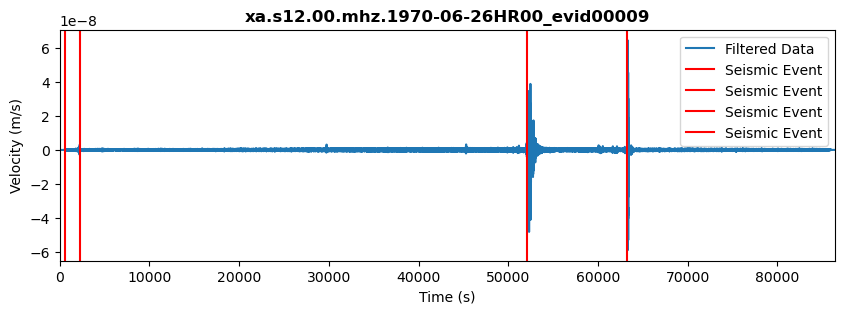

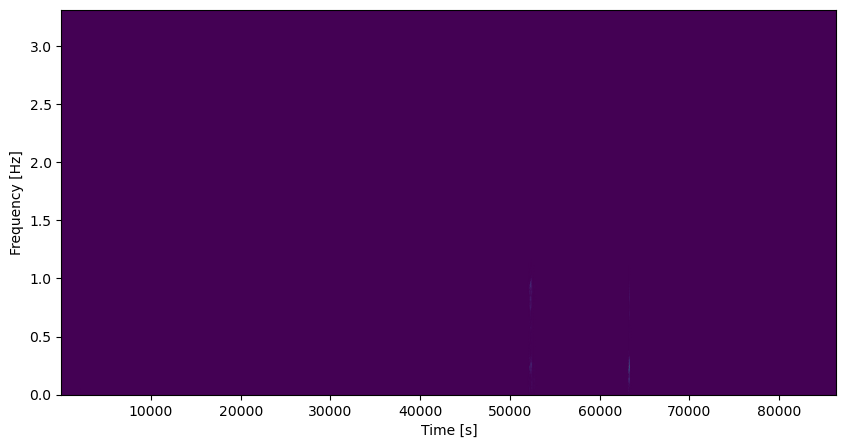

In [44]:
import numpy as np
import pandas as pd
from obspy import read
from obspy.signal.trigger import classic_sta_lta, trigger_onset
from obspy.core import UTCDateTime
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Example usage for reading a catalog
# cat_directory = r'C:\Users\R Durga Bhavani\Downloads\space_apps_2024_seismic_detection\space_apps_2024_seismic_detection\data\lunar\training\catalogs\apollo12_catalog_GradeA_final.csv'
# cat_file = cat_directory 
# cat = pd.read_csv(cat_file)

# Select a seismic event from the catalog
# row = cat.iloc[6]
# arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], '%Y-%m-%dT%H:%M:%S.%f')
# arrival_time_rel = row['time_rel(sec)']
# test_filename = row.filename

test_filenames_mseed = [
    "xa.s16.00.mhz.1972-09-10HR00_evid00075",
    "xa.s16.00.mhz.1972-11-06HR00_evid00079",
    "xa.s16.00.mhz.1972-11-08HR00_evid00080",
    "xa.s16.00.mhz.1972-11-14HR00_evid00081",
    "xa.s16.00.mhz.1973-07-31HR00_evid00123",
    "xa.s16.00.mhz.1974-05-19HR00_evid00146",
    "xa.s16.00.mhz.1974-11-11HR00_evid00160",
    "xa.s16.00.mhz.1974-12-12HR02_evid00168",
    "xa.s16.00.mhz.1974-12-15HR00_evid00172",
    "xa.s16.00.mhz.1974-12-25HR00_evid00174",
    "xa.s16.00.mhz.1975-02-19HR00_evid00180",
    "xa.s16.00.mhz.1975-03-26HR00_evid00186",
    "xa.s16.00.mhz.1977-04-17HR00_evid00249",
    "xa.s16.00.mhz.1977-06-02HR00_evid00255",
]

# Directory containing the MiniSEED files
data_directory = r'C:\Users\R Durga Bhavani\Downloads\space_apps_2024_seismic_detection\space_apps_2024_seismic_detection\data\lunar\test\data\S16_GradeA'

# Loop through the test filenames
for filename in test_filenames:
    mseed_file = f'{data_directory}\\{filename}.mseed'
    
    # Read the MiniSEED file
    try:
        st = read(mseed_file)
    except Exception as e:
        print(f"Error reading {mseed_file}: {e}")
        continue  # Skip this file and continue with the next one

    # Extract trace data
    tr = st[0].copy()
    tr_times = tr.times()
    tr_data = tr.data
    fs = tr.stats.sampling_rate  # Sampling frequency

    # Apply bandpass filter (to handle planetary-specific noise and anomalies)
    lowcut = 0.01  # Adjust to target specific seismic frequencies
    highcut = 1.0
    tr_data_filt = bandpass_filter(tr_data, lowcut, highcut, fs)

    # Handle missing data after filtering
    tr_data_filt = handle_missing_data(tr_data_filt)

# Function to handle missing data
def handle_missing_data(data):
    data = np.nan_to_num(data)  # Replace NaN with zeros
    return data


tr_data_filt = handle_missing_data(tr_data_filt)

# Apply Short-Term Average / Long-Term Average (STA/LTA) algorithm
sta_len = 120  # Short-term window in seconds
lta_len = 600  # Long-term window in seconds
df = fs  # Sampling frequency
cft = classic_sta_lta(tr_data_filt, int(sta_len * df), int(lta_len * df))

# Plot characteristic function for STA/LTA
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.plot(tr_times, cft)
ax.set_xlim([min(tr_times), max(tr_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic Function')

# Define trigger thresholds and identify seismic events
thr_on = 4  # On threshold
thr_off = 1.5  # Off threshold
on_off = np.array(trigger_onset(cft, thr_on, thr_off))

# Plot triggers
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
for i in range(len(on_off)):
    triggers = on_off[i]
    ax.axvline(x=tr_times[triggers[0]], color='red', label='Trig. On')
    ax.axvline(x=tr_times[triggers[1]], color='purple', label='Trig. Off')

# Plot filtered trace with marked detections
ax.plot(tr_times, tr_data_filt)
ax.set_xlim([min(tr_times), max(tr_times)])
ax.legend()

# Convert time to absolute
starttime = tr.stats.starttime.datetime
detection_times = []
fnames = []
for i in range(len(on_off)):
    triggers = on_off[i]
    on_time = starttime + timedelta(seconds=tr_times[triggers[0]])
    detection_times.append(on_time)
    fnames.append(test_filename)

# Compile detected events into a DataFrame and export to CSV
detect_df = pd.DataFrame({
    'filename': fnames, 
    'time_abs(%Y-%m-%dT%H:%M:%S.%f)': [dt.strftime('%Y-%m-%dT%H:%M:%S.%f') for dt in detection_times],
    'time_rel(sec)': tr_times[on_off[:, 0]]
})

detect_df.to_csv('output/dettects_catalog.csv', index=False)

# Optional: Machine Learning Approach (If Applicable)
# You could add a section here using libraries such as scikit-learn or TensorFlow
# to train a machine learning model for automatic detection using seismic data
# from both Earth and planetary datasets.

# Visualization of Seismic Data (Creativity)
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(tr_times, tr_data_filt, label='Filtered Data')
ax.set_xlim([min(tr_times), max(tr_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Mark event detections on the plot
for trigger in on_off:
    ax.axvline(x=tr_times[trigger[0]], color='red', label='Seismic Event')

plt.legend()
plt.show()

# Optional: Spectrogram visualization for additional data representation
from scipy import signal
f, t, Sxx = signal.spectrogram(tr_data_filt, fs)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.pcolormesh(t, f, Sxx, shading='gouraud')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [s]')
plt.show()


# For CSV files

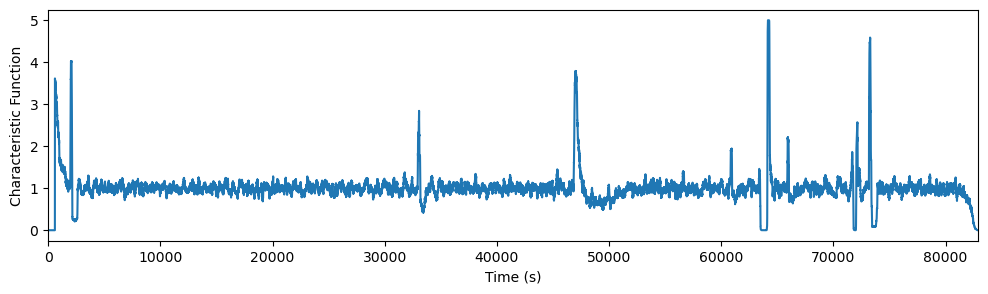

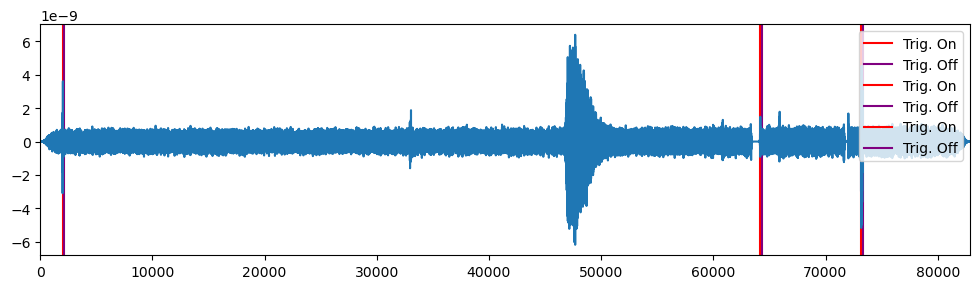

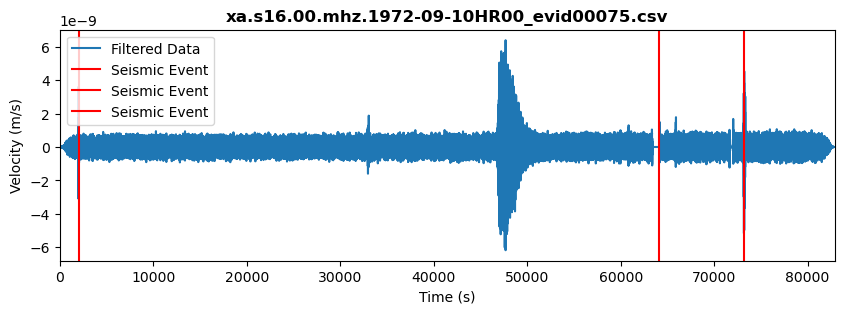

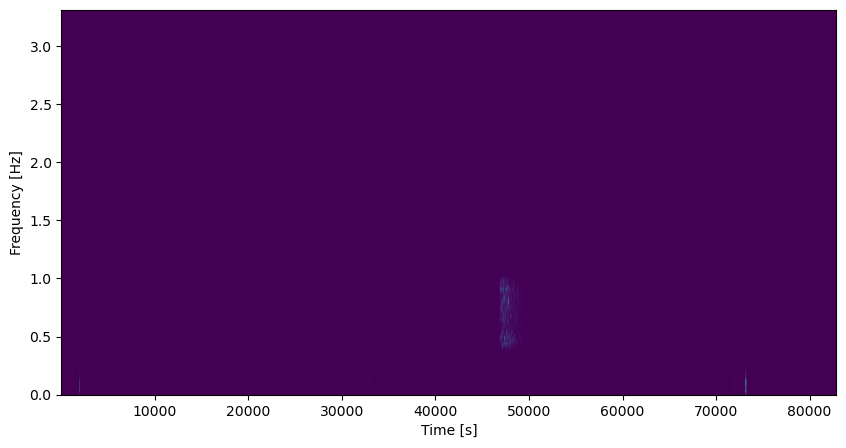

No triggers found in xa.s16.00.mhz.1972-11-06HR00_evid00079.csv. Skipping event detection.
No triggers found in xa.s16.00.mhz.1972-11-08HR00_evid00080.csv. Skipping event detection.


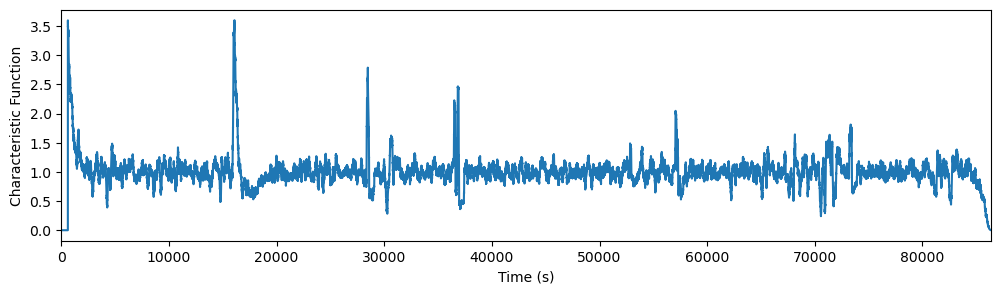

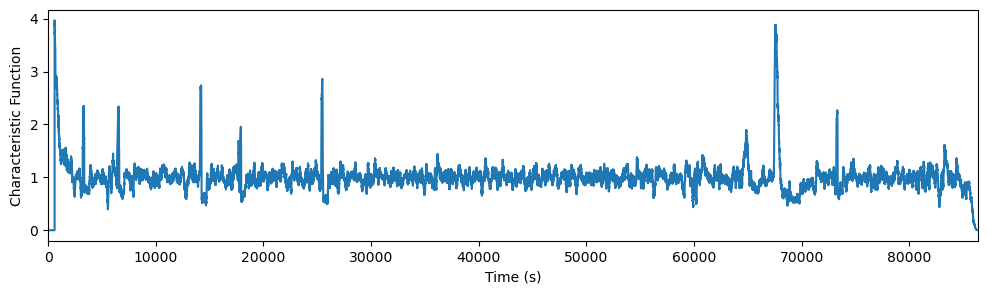

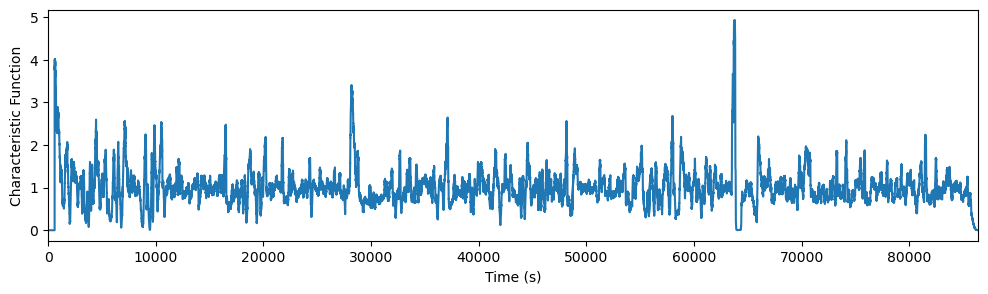

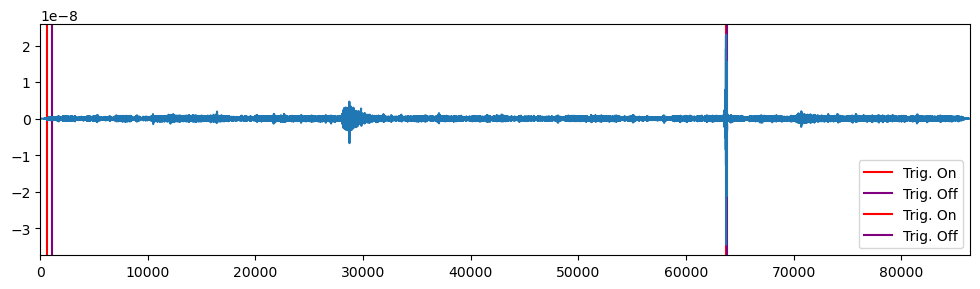

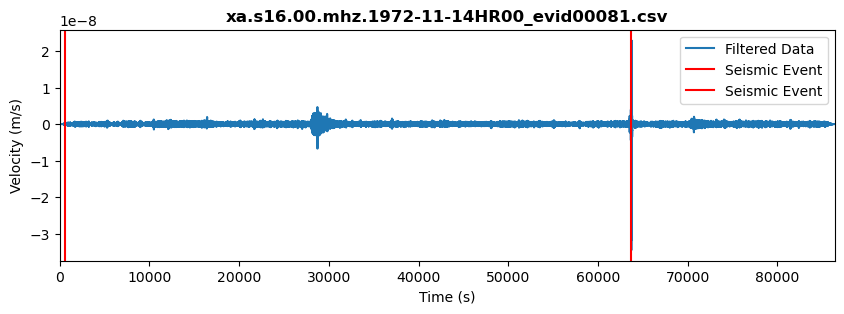

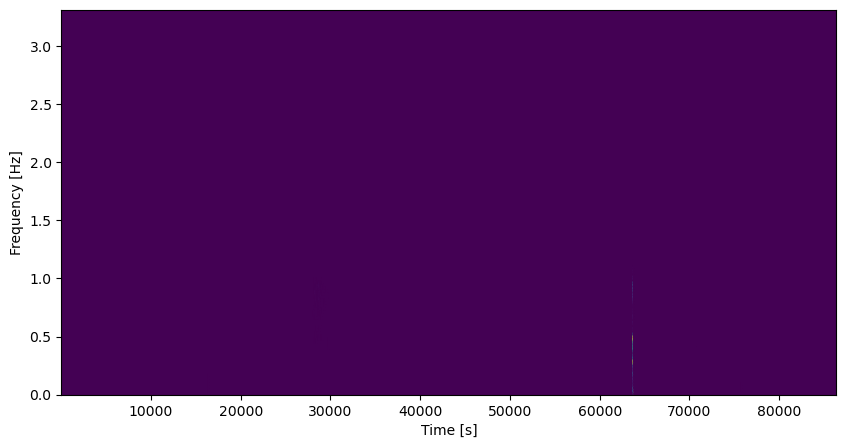

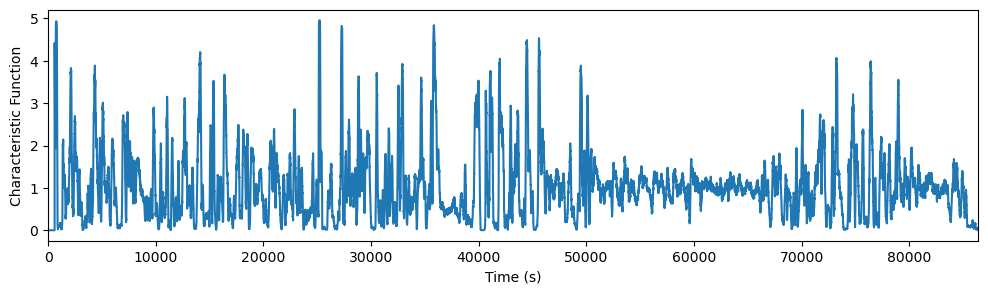

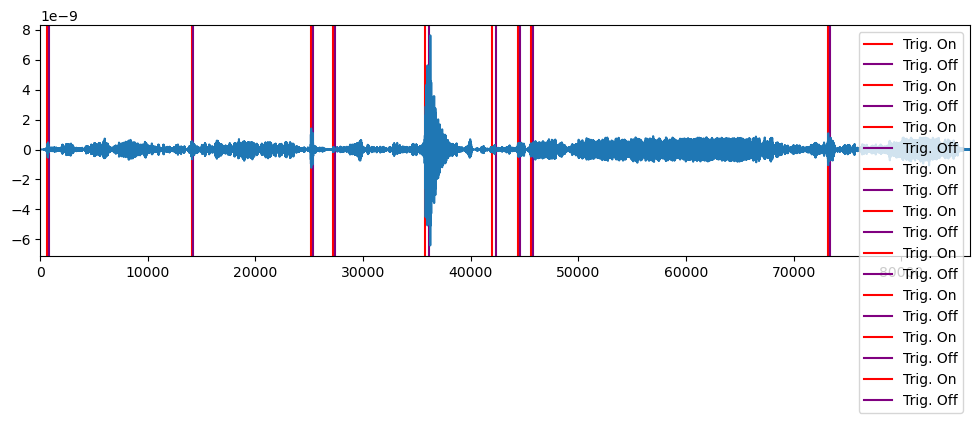

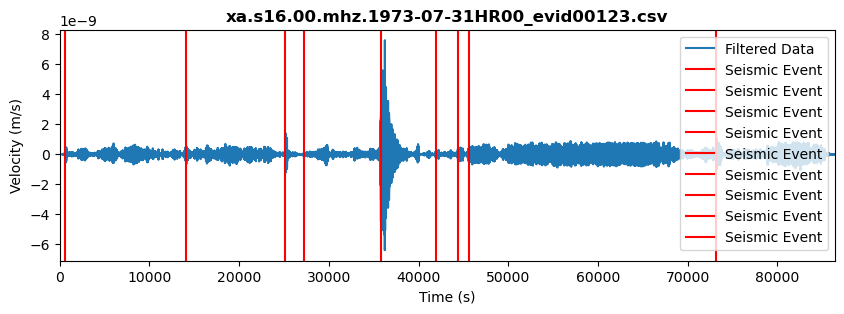

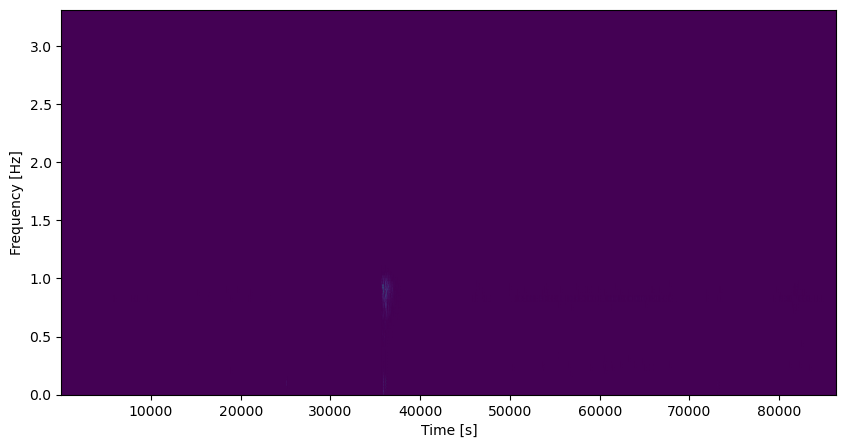

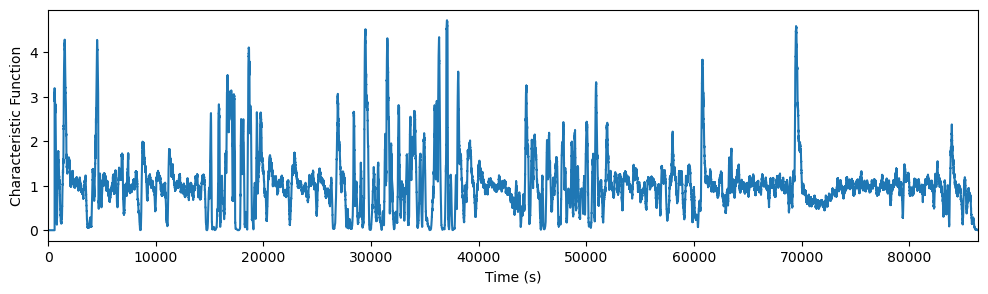

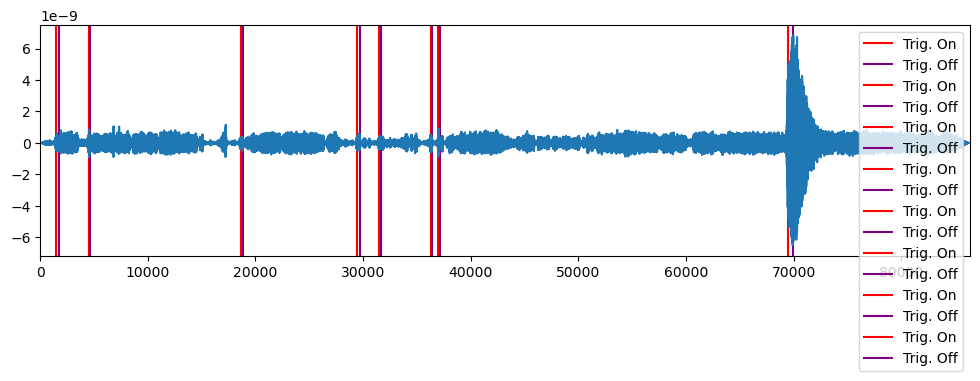

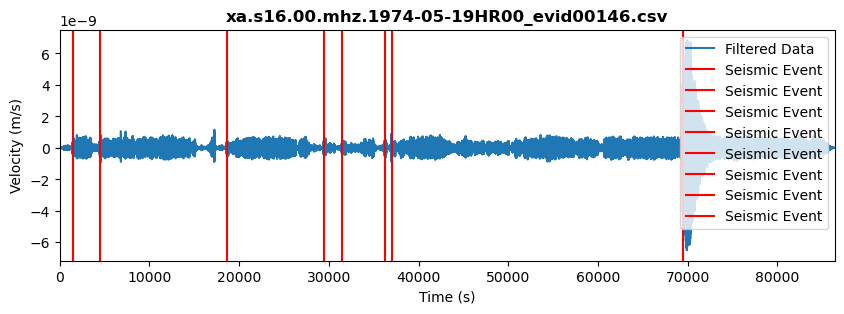

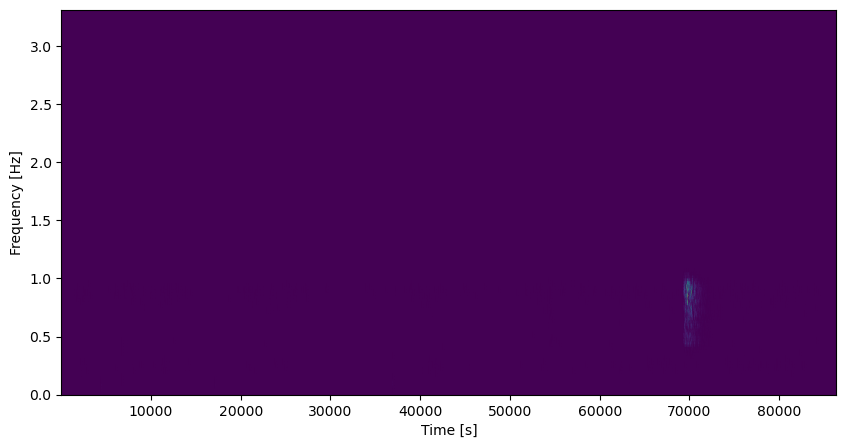

PermissionError: [Errno 13] Permission denied: 'output\\detect_catalog_for_csv.csv'

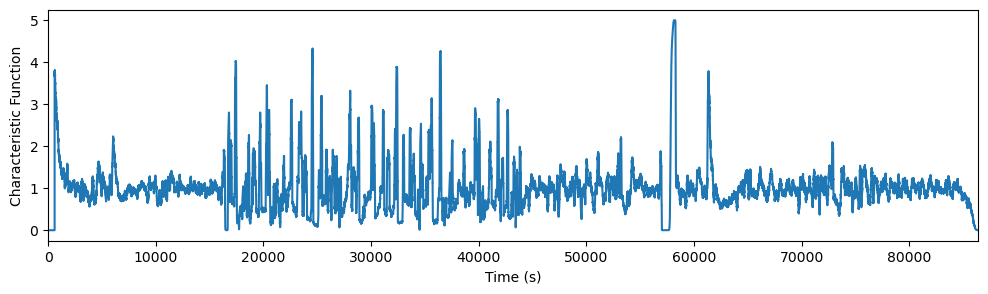

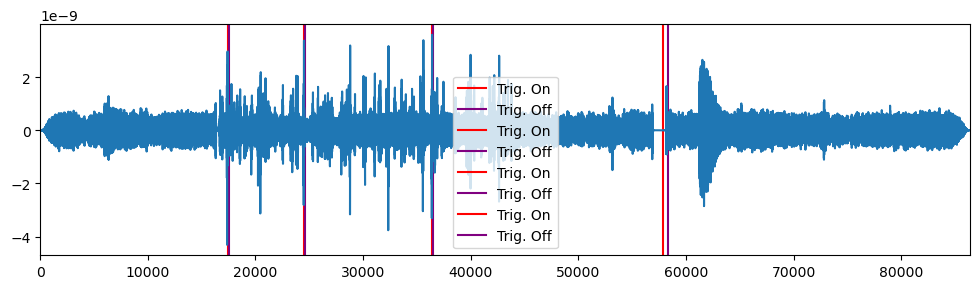

In [54]:
import os
import numpy as np
import pandas as pd
from obspy.signal.trigger import classic_sta_lta, trigger_onset
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import glob

# Bandpass filter functions
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Function to handle missing data
def handle_missing_data(data):
    data = np.nan_to_num(data)  # Replace NaN with zeros
    return data

# Provided grade value
grade_value = 'S16_GradeA'  # This can be changed dynamically

# Base directory (update the path as per your directory structure)
base_directory = r'C:\Users\R Durga Bhavani\Downloads\space_apps_2024_seismic_detection\space_apps_2024_seismic_detection\data\lunar\test\data'

# Construct the directory path for the provided grade
grade_directory = os.path.join(base_directory, grade_value)

# List to store CSV files found
csv_files = []

# Traverse through the grade directory and get all CSV files
for filepath in glob.iglob(os.path.join(grade_directory, '*.csv')):
    csv_files.append(filepath)

    # Read the CSV file containing seismic data
    try:
        df = pd.read_csv(filepath)
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        continue  # Skip this file and continue with the next one

    # Extract time and velocity data from the CSV
    tr_times_abs = pd.to_datetime(df['time_abs(%Y-%m-%dT%H:%M:%S.%f)'])
    tr_times_rel = df['time_rel(sec)'].values
    tr_data = df['velocity(m/s)'].values
    fs = 1 / (tr_times_rel[1] - tr_times_rel[0])  # Calculate sampling frequency from time intervals
    
    # Apply bandpass filter (to handle planetary-specific noise and anomalies)
    lowcut = 0.01  # Adjust to target specific seismic frequencies
    highcut = 1.0
    tr_data_filt = bandpass_filter(tr_data, lowcut, highcut, fs)

    # Handle missing data after filtering
    tr_data_filt = handle_missing_data(tr_data_filt)

    # Apply Short-Term Average / Long-Term Average (STA/LTA) algorithm
    sta_len = 120  # Short-term window in seconds
    lta_len = 600  # Long-term window in seconds
    cft = classic_sta_lta(tr_data_filt, int(sta_len * fs), int(lta_len * fs))

    # Plot characteristic function for STA/LTA
    fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    ax.plot(tr_times_rel, cft)
    ax.set_xlim([min(tr_times_rel), max(tr_times_rel)])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Characteristic Function')

    # Define trigger thresholds and identify seismic events
    thr_on = 4  # On threshold
    thr_off = 1.5  # Off threshold
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))

    # Only proceed if triggers were found
    if len(on_off) > 0:
        # Plot triggers
        fig, ax = plt.subplots(1, 1, figsize=(12, 3))
        for i in range(len(on_off)):
            triggers = on_off[i]
            ax.axvline(x=tr_times_rel[triggers[0]], color='red', label='Trig. On')
            ax.axvline(x=tr_times_rel[triggers[1]], color='purple', label='Trig. Off')

        # Plot filtered trace with marked detections
        ax.plot(tr_times_rel, tr_data_filt)
        ax.set_xlim([min(tr_times_rel), max(tr_times_rel)])
        ax.legend()

        # Convert relative time to absolute
        starttime = tr_times_abs[0]
        detection_times = []
        fnames = []
        for i in range(len(on_off)):
            triggers = on_off[i]
            on_time = starttime + timedelta(seconds=tr_times_rel[triggers[0]])
            detection_times.append(on_time)
            fnames.append(os.path.basename(filepath))  # Get the file name

        # Compile detected events into a DataFrame and export to CSV
        detect_df = pd.DataFrame({
            'filename': fnames, 
            'time_abs(%Y-%m-%dT%H:%M:%S.%f)': [dt.strftime('%Y-%m-%dT%H:%M:%S.%f') for dt in detection_times],
            'time_rel(sec)': tr_times_rel[on_off[:, 0]]
        })

        # Ensure output directory exists
        output_dir = 'output'
        os.makedirs(output_dir, exist_ok=True)
        detect_df.to_csv(os.path.join(output_dir, 'detect_catalog_for_csv.csv'), index=False)

        # Visualization of Seismic Data
        fig, ax = plt.subplots(1, 1, figsize=(10, 3))
        ax.plot(tr_times_rel, tr_data_filt, label='Filtered Data')
        ax.set_xlim([min(tr_times_rel), max(tr_times_rel)])
        ax.set_ylabel('Velocity (m/s)')
        ax.set_xlabel('Time (s)')
        ax.set_title(f'{os.path.basename(filepath)}', fontweight='bold')

        # Mark event detections on the plot
        for trigger in on_off:
            ax.axvline(x=tr_times_rel[trigger[0]], color='red', label='Seismic Event')

        plt.legend()
        plt.show()

        # Optional: Spectrogram visualization for additional data representation
        from scipy import signal
        f, t, Sxx = signal.spectrogram(tr_data_filt, fs)
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax.pcolormesh(t, f, Sxx, shading='gouraud')
        ax.set_ylabel('Frequency [Hz]')
        ax.set_xlabel('Time [s]')
        plt.show()

    else:
        print(f"No triggers found in {os.path.basename(filepath)}. Skipping event detection.")


In [58]:
import pandas as pd

# Load the detected events from CSV
detected_df = pd.read_csv('output/detect_catalog_for_csv.csv')  # Update with your actual path
ground_truth_df = pd.read_csv(r'C:\Users\R Durga Bhavani\Downloads\apollo12_catalog_GradeA_final-dur.csv')  # Update with your ground truth CSV path

# Ensure the time columns are in datetime format
detected_df['time_abs(%Y-%m-%dT%H:%M:%S.%f)'] = pd.to_datetime(detected_df['time_abs(%Y-%m-%dT%H:%M:%S.%f)'])
ground_truth_df['time_abs(%Y-%m-%dT%H:%M:%S.%f)'] = pd.to_datetime(ground_truth_df['time_abs(%Y-%m-%dT%H:%M:%S.%f)'])

# Accuracy check code
matched_events = sum(
    detected_df['time_abs(%Y-%m-%dT%H:%M:%S.%f)'].apply(lambda x: any(abs(x - y) <= pd.Timedelta(seconds=5) for y in ground_truth_df['time_abs(%Y-%m-%dT%H:%M:%S.%f)']))
)

accuracy = (matched_events / len(detected_df)) * 100 if len(detected_df) > 0 else 0
print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 0.00%
